In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModel
from transformers.utils.logging import enable_propagation
import json
import pandas as pd
import matplotlib
import numpy as np
from transformers import pipeline
from tqdm import tqdm

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'additional_special_tokens': ['[E1S]', '[E1E]','[E2S]', '[E2E]']})
model.resize_token_embeddings(len(tokenizer))

pipe = pipeline('feature-extraction', model=model, tokenizer=tokenizer)

## Try untrained BERT on DocReD

In [5]:
from datasets import load_dataset

dataset = load_dataset("docred")
#

In [6]:
docred_rel2id = json.load(open('./rel2id.json', 'r'))
pandas_input = {'sentences': [], 'relation_type': [], 'relation_name': [], 'descr': [], 'e1': [], 'e2': []}

for index in range(len(dataset['train_annotated'])):
    sample = dataset['train_annotated'][index]
    entities = sample['vertexSet']

    # iterate over relationships
    for (i,x) in enumerate(sample['labels']['relation_id']):
        label = sample['labels']
        relation_type = int(docred_rel2id[label['relation_id'][i]])
        relation_name = label['relation_text'][i]

        head_entity = label['head'][i]
        tail_entity = label['tail'][i]

        if(len(entities[head_entity]) > 1 or len(entities[tail_entity]) > 1):
            # skip ambigious relations
            continue 

        head_entity = entities[head_entity][0]
        tail_entity = entities[tail_entity][0]
        descr = "".join([head_entity["name"], " -> ", relation_name, " -> ", tail_entity["name"]])
        
        pandas_input['sentences'].append(sample['sents'])
        pandas_input['relation_type'].append(relation_type)
        pandas_input['relation_name'].append(relation_name)
        pandas_input['descr'].append(descr)
        pandas_input['e1'].append(head_entity)
        pandas_input['e2'].append(tail_entity)


In [7]:
df = pd.DataFrame.from_dict(pandas_input)

In [8]:
df.iloc[23].e1['type']

'LOC'

In [9]:
df.relation_name.value_counts().head(20)

country                                             4537
located in the administrative territorial entity    1961
contains administrative territorial entity           976
country of citizenship                               812
publication date                                     591
performer                                            354
record label                                         297
part of                                              287
date of birth                                        252
has part                                             251
country of origin                                    227
continent                                            195
cast member                                          191
date of death                                        186
present in work                                      134
conflict                                             121
author                                               120
member of                      

In [10]:
def tag_words(sentences, head_entity, tail_entity):
    words = []
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentence):
            if head_entity['sent_id'] == i and j == head_entity['pos'][0]:
                words.append('[E1S]')

            if tail_entity['sent_id'] == i and j == tail_entity['pos'][0]:
                words.append('[E2S]')

            if head_entity['sent_id'] == i and j == head_entity['pos'][1]: 
                words.append('[E1E]')

            if tail_entity['sent_id'] == i and j == tail_entity['pos'][1]:
                words.append('[E2E]')


            words.append(word)
    
    return words


In [11]:
valid_groups = df['relation_name'].value_counts()[df['relation_name'].value_counts() >= 50].index
filtered_df = df[df['relation_name'].isin(valid_groups)]
result_df = filtered_df.groupby('relation_name', group_keys=False).apply(lambda x: x.sample(min(len(x), 50)))

In [12]:
analysis_df = {'type': [], 'e_emb': [], 'cls_emb': [], 'descr': []}

for index, row in tqdm(result_df.iterrows()):
    
    tagged_sentence = " ".join(tag_words(row['sentences'], row['e1'], row['e2']))
    
    tokens = tokenizer(tagged_sentence)
    
    if(len(tokens.input_ids) > 512):
        print("input seq too long")
        continue
    
    emb = pipe(tagged_sentence)

    start_e1 = tokens.input_ids.index(tokenizer.get_added_vocab()['[E1S]'])
    start_e2 = tokens.input_ids.index(tokenizer.get_added_vocab()['[E2S]'])
   
    entity_tags_emb = np.concatenate((np.array(emb[0][start_e1]), np.array(emb[0][start_e2])))

    cls_emb = np.array(emb[0][0])
    
    analysis_df['type'].append(row['relation_type'])
    analysis_df['e_emb'].append(entity_tags_emb)
    analysis_df['cls_emb'].append(cls_emb)
    analysis_df['descr'].append(row['descr'])
    

345it [00:15, 22.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors
352it [00:16, 23.31it/s]

input seq too long


1036it [00:49, 16.63it/s]

input seq too long


1569it [01:16, 23.23it/s]

input seq too long


2311it [01:55, 21.93it/s]

input seq too long


2338it [01:56, 21.40it/s]

input seq too long


2467it [02:03, 22.11it/s]

input seq too long


2473it [02:04, 19.37it/s]

input seq too long


2755it [02:18, 21.58it/s]

input seq too long


2794it [02:21, 20.57it/s]

input seq too long


2800it [02:21, 19.81it/s]


In [13]:
adf = pd.DataFrame.from_dict(analysis_df)

In [14]:
adf.shape

(2791, 4)

In [15]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import umap


In [16]:
len(adf.e_emb[0].tolist())

1536

In [59]:
reducer = umap.UMAP()
embedding = reducer.fit_transform([e.tolist() for e in adf.e_emb])
embedding.shape

(2790, 2)

/var/folders/9f/bjds83ns5rg63wt1n9vq63s00000gn/T/ipykernel_13060/3419054836.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


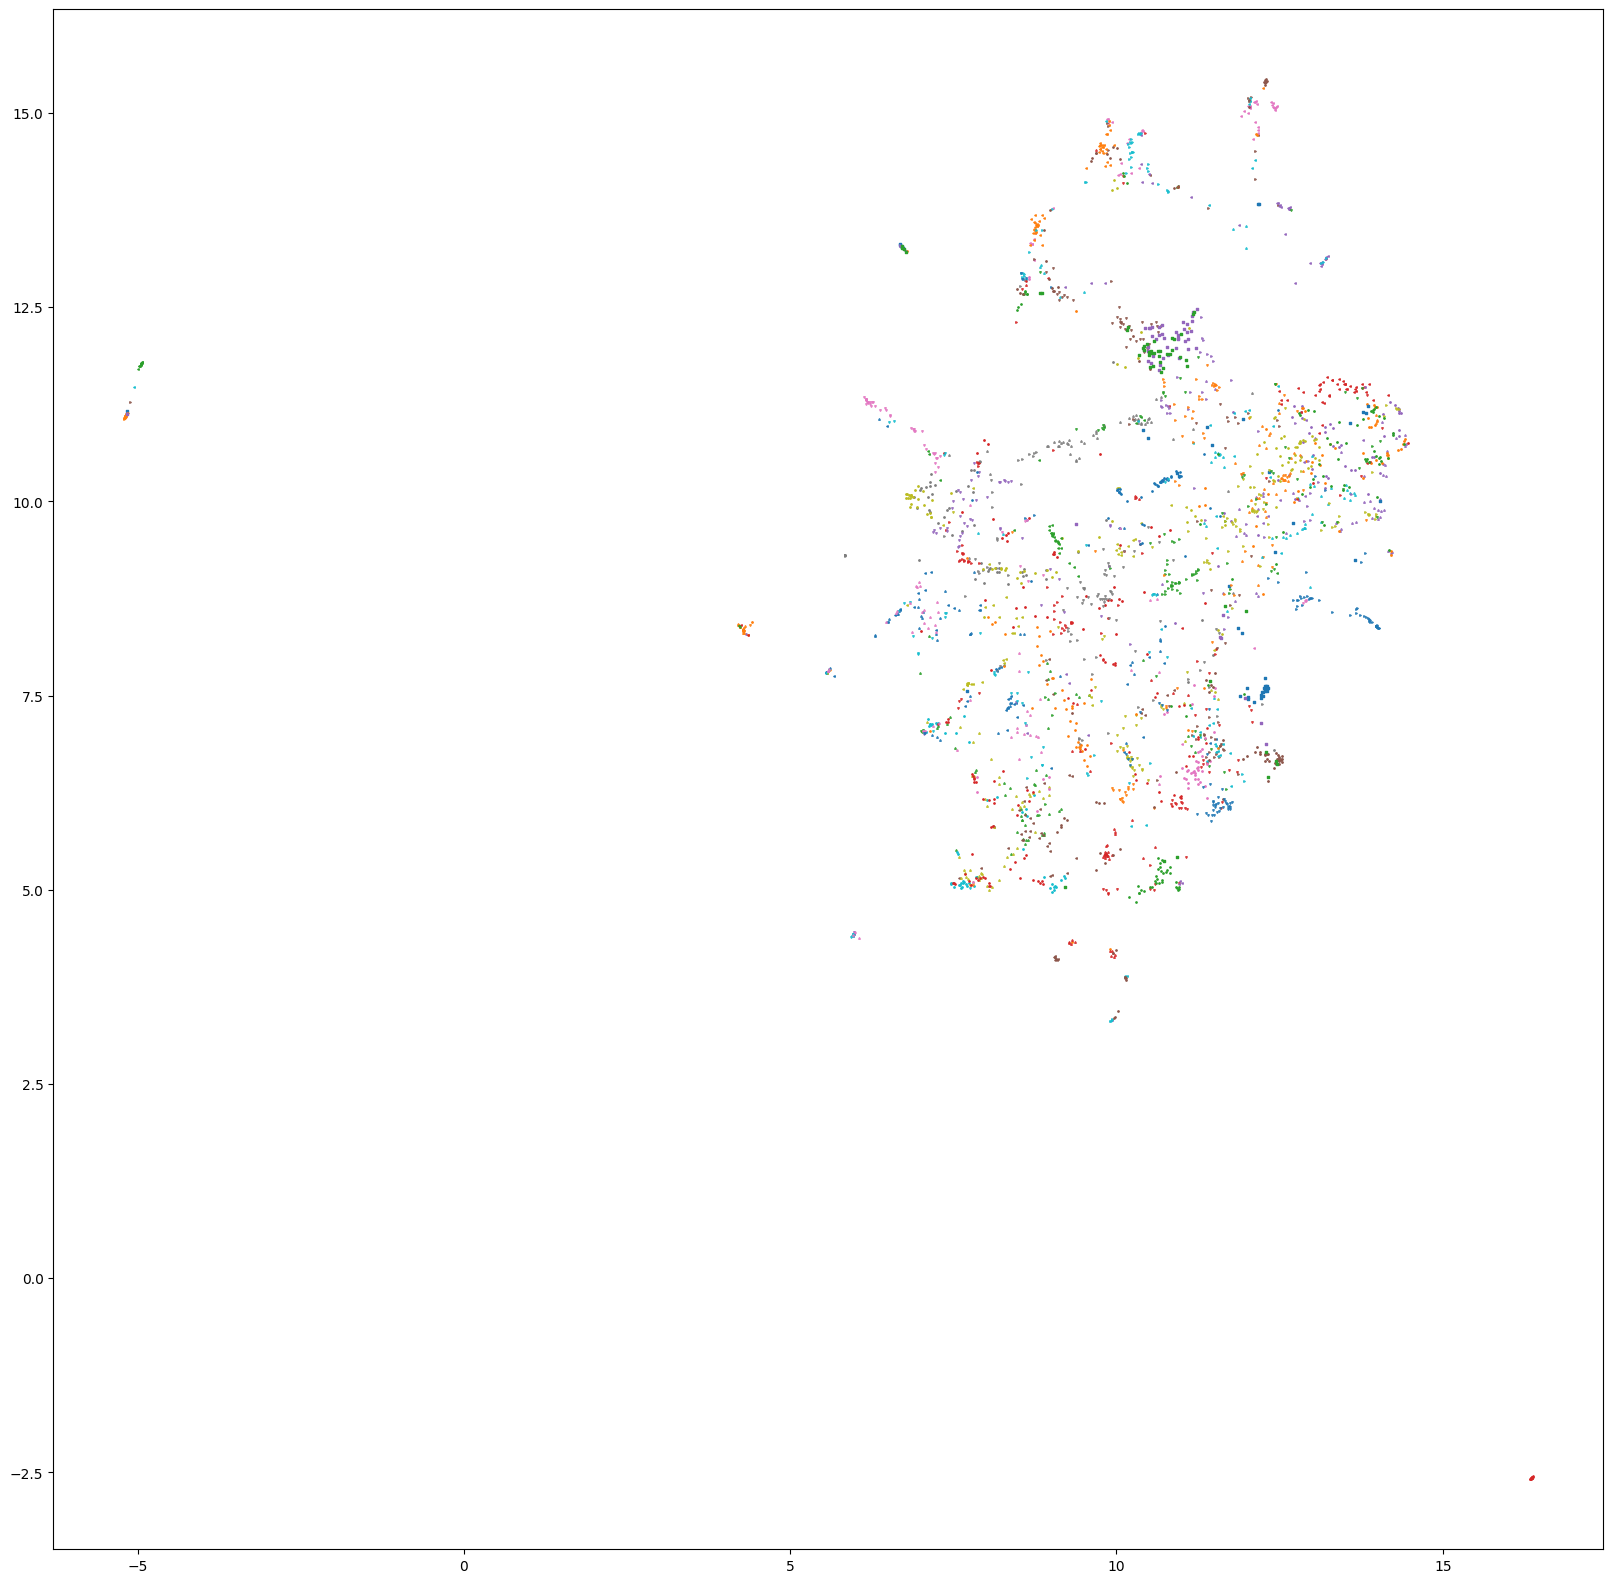

In [24]:
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
ms = [markers[int(x / len(sns.color_palette())) % len(markers)] for x in adf['type']]
colors = [sns.color_palette()[x % len(sns.color_palette())] for x in adf['type']]

plt.figure(figsize=(20, 20))

for i in range(len(adf)):
    plt.scatter(
        embedding[i, 0],
        embedding[i, 1],
        s=1,
        marker=ms[i],
        c=colors[i]
    )
plt.savefig('t.pdf')
plt.show()

In [60]:
adf["type"] = adf["type"].astype(str)

import plotly.express as px
fig = px.scatter(adf, x=embedding[:, 0], y=embedding[:, 1], color='type', hover_data={'descr': True})
fig.update_traces(marker=dict(size=3))
fig.show()


In [61]:
fig.write_html("embedding.html")

In [33]:
adf.head()

type                                              e_emb  \
0    24  [-0.27499502897262573, -0.08585908263921738, -...   
1    24  [0.14233970642089844, -0.13037973642349243, 0....   
2    24  [-0.24470587074756622, -0.3024555444717407, 0....   
3    24  [-0.3518480360507965, 0.009257061406970024, -0...   
4    24  [-0.4686800539493561, 0.08210906386375427, -0....   

                                             cls_emb  \
0  [-0.04479195550084114, 0.25363749265670776, -0...   
1  [-0.15365692973136902, 0.17058703303337097, -0...   
2  [-0.3253265917301178, -0.27671992778778076, -0...   
3  [-0.21917277574539185, 0.15643873810768127, -0...   
4  [-0.18602536618709564, 0.15112949907779694, -0...   

                                               descr  
0  Norwegian Parliament -> applies to jurisdictio...  
1        UN Charter -> applies to jurisdiction -> UN  
2    Congress -> applies to jurisdiction -> Peruvian  
3  the United States Senate -> applies to jurisdi...  
4  Maine House of Representatives -> applies to j...

## Let's see how well these embeddings are working

In [34]:
# Random guessing would be:
print(f"Accuracy: {1 / len(adf.type.unique()) * 100:.2f}%")

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X = adf['cls_emb'].values
y = adf['type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train.tolist(), y_train)

y_pred = knn_classifier.predict(X_test.tolist())

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

The Accuracy using the CLS tokens of the embeddings is in the range of 25%, which is okay!

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = adf['e_emb'].values
y = adf['type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train.tolist(), y_train)

y_pred = knn_classifier.predict(X_test.tolist())

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

class_report = classification_report(y_test, y_pred, output_dict=True)


Using the entity marker special tokens, we achieve an accuracy of nearly 60%, quite a difference!

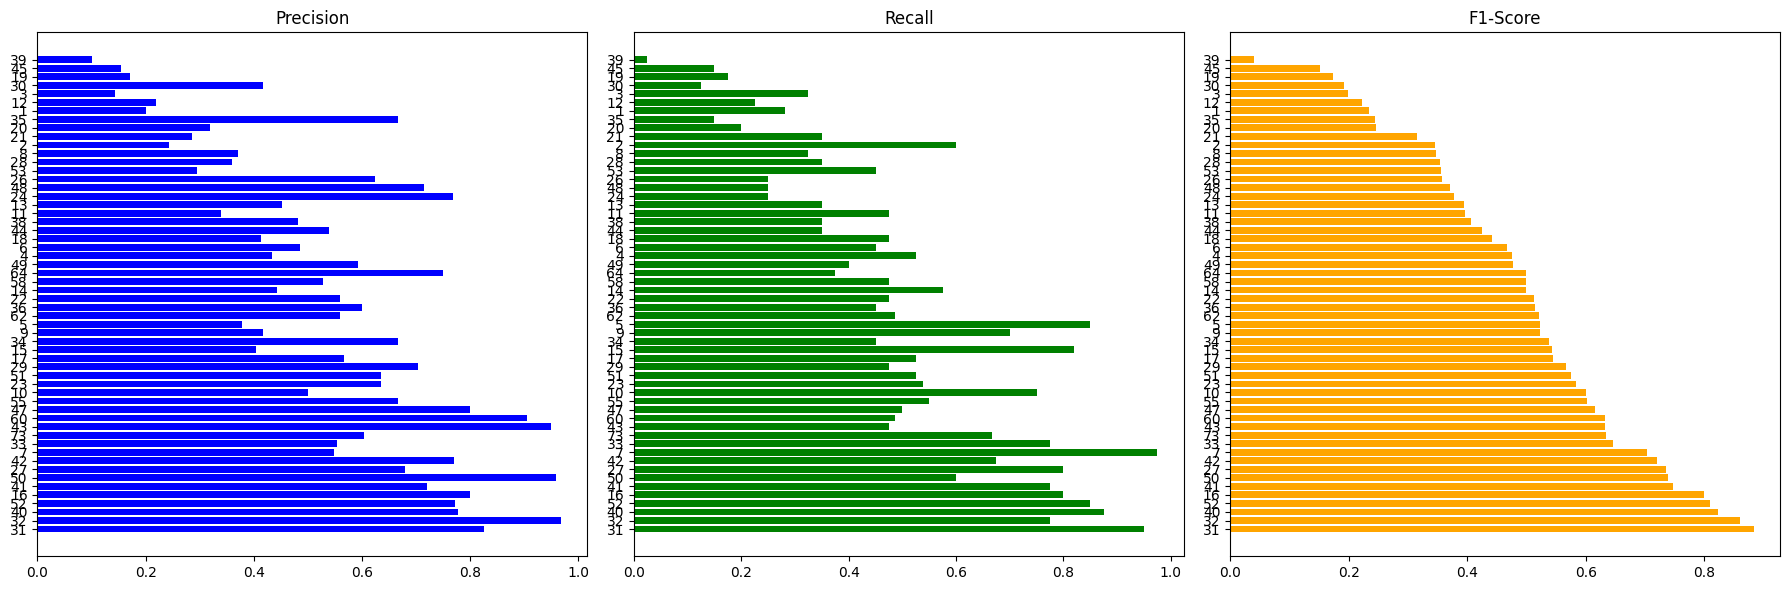

In [108]:
classes = [str(class_label) for class_label in class_report.keys() if class_label.isdigit()]  # Assuming class labels are integers
precision = [class_report[class_label]['precision'] for class_label in classes]
recall = [class_report[class_label]['recall'] for class_label in classes]
f1 = [class_report[class_label]['f1-score'] for class_label in classes]

# Sort classes based on F1-score
sorted_indices = sorted(range(len(f1)), key=lambda k: f1[k], reverse=True)
classes_sorted = [classes[i] for i in sorted_indices]
precision_sorted = [precision[i] for i in sorted_indices]
recall_sorted = [recall[i] for i in sorted_indices]
f1_sorted = [f1[i] for i in sorted_indices]

# Plotting subplots with different colors
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Precision subplot
axs[0].barh(classes_sorted, precision_sorted, color='blue')
axs[0].set_title('Precision')

# Recall subplot
axs[1].barh(classes_sorted, recall_sorted, color='green')
axs[1].set_title('Recall')

# F1-score subplot
axs[2].barh(classes_sorted, f1_sorted, color='orange')
axs[2].set_title('F1-Score')

plt.tight_layout()
plt.show()

In [109]:
output

array([26,  3, 11, 33, 41,  5, 45, 10,  8, 49, 34, 21,  4, 50, 43, 31, 52,
       48, 44, 32, 19, 53, 37, 38, 20, 51, 39, 29, 28,  0, 16,  9, 55, 35,
       12, 22, 25, 23, 15, 46, 47, 18, 42, 17, 27, 40, 30, 24, 36, 14, 54,
        1,  2, 13,  7,  6], dtype=int32)

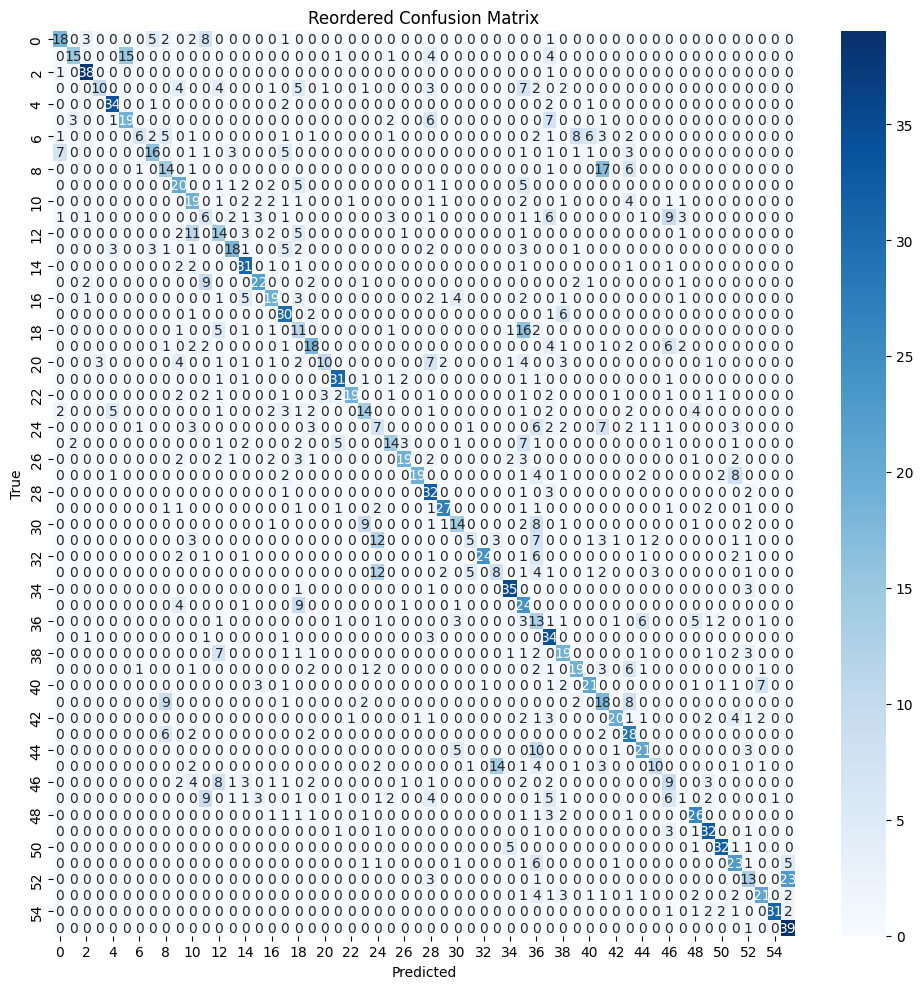

In [110]:
# Step 7: Confusion matrix
cm = confusion_matrix(y_test, y_pred)

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

graph = csr_matrix(cm > 0.05)
output = reverse_cuthill_mckee(graph, symmetric_mode=False)

reordered_cm = cm[:, output][output, :]

# Plot the original and reordered confusion matrices using seaborn heatmap
fig, axes = plt.subplots(1, 1, figsize=(10, 10))


sns.heatmap(reordered_cm, annot=True, fmt='d', cmap='Blues', ax=axes)
axes.set_title('Reordered Confusion Matrix')
axes.set_xlabel('Predicted')
axes.set_ylabel('True')

plt.tight_layout()
plt.show()





In [117]:
cm[:,[1,2,33]][[1,2,33],:]

array([[24,  0,  0],
       [ 3, 13,  0],
       [ 0,  2,  6]])

Overall Accuracy: 42.52%


/Users/moritzduck/miniconda3/envs/leaks/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



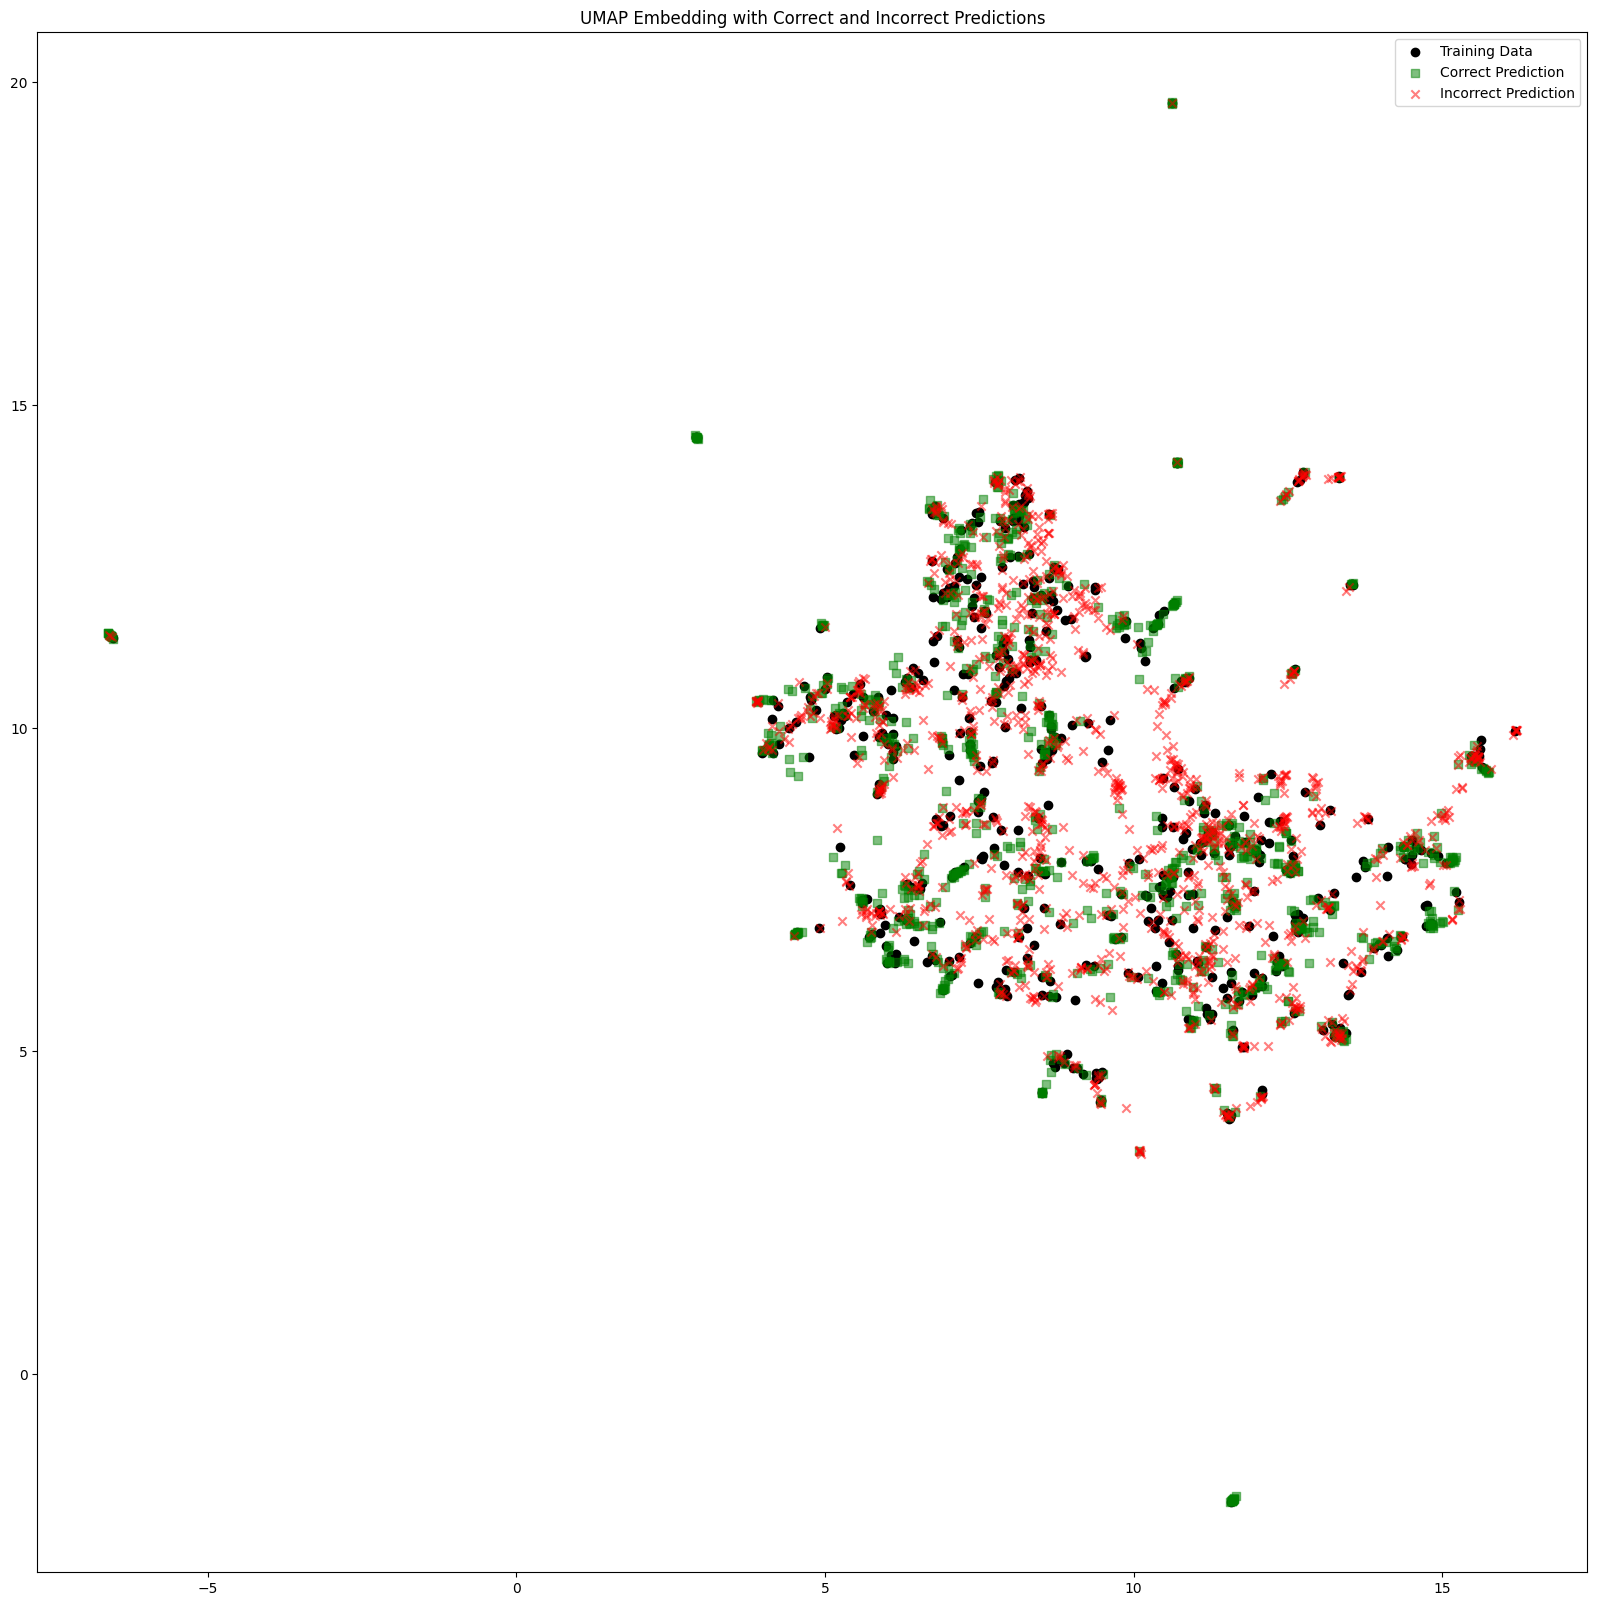

In [310]:
X = np.stack(adf['e_emb'].values)
y = adf['type'].values

# Step 2: Split the data into training and test sets with an even distribution of classes in the training set
X_train, X_test, X_train_i, X_test_i, y_train, y_test = train_test_split(X,np.arange(X.shape[0]), y, test_size=0.8, stratify=y, random_state=42)

# Step 3: Train a KNN classifier on the training set
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Step 5: Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Step 6: Create a UMAP embedding of the data
umap_emb = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=41)
umap_result = umap_emb.fit_transform(X)

# Step 7: Plot the UMAP embedding with different markers for correct and incorrect predictions
fig, ax = plt.subplots(figsize=(20, 20))

# Plot all points in light gray
ax.scatter(umap_result[X_train_i][:, 0], umap_result[X_train_i][:, 1], color='black', marker='o', label='Training Data')

# Mark correctly predicted points with green square
correct_mask = y_test == y_pred
umap_result_test = umap_result[X_test_i]
ax.scatter(umap_result_test[y_test == y_pred, 0], umap_result_test[y_test == y_pred, 1], color='green', alpha=0.5, marker='s', label='Correct Prediction')

# Mark incorrectly predicted points with red 'x'
ax.scatter(umap_result_test[y_test != y_pred, 0], umap_result_test[y_test != y_pred, 1], color='red',alpha=0.5, marker='x', label='Incorrect Prediction')

ax.set_title('UMAP Embedding with Correct and Incorrect Predictions')
ax.legend()
plt.show()

Let's see what happens if we have less annotations

In [311]:
X = np.stack(adf['e_emb'].values)
y = adf['type'].values

# Step 2: Split the data into training and test sets with an even distribution of classes in the training set
X_train, X_test, X_train_i, X_test_i, y_train, y_test = train_test_split(X, np.arange(X.shape[0]), y, test_size=0.8, stratify=y, random_state=42)

# Step 3: Train a KNN classifier on the training set
knn_classifier = KNeighborsClassifier(n_neighbors=15)  # You can adjust the number of neighbors
knn_classifier.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Step 5: Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Step 6: Get the indices and class labels of the 15 nearest neighbors for each sample
neigh_dist, neigh_ind = knn_classifier.kneighbors(X_test, n_neighbors=15, return_distance=True)

# Step 7: Get the class distribution of the 15 nearest neighbors per sample
neighbor_class_distribution = y_train[neigh_ind]

# Step 8: Display the class distribution
columns = [f'Neighbor_{i+1}' for i in range(15)]
neighbor_class_df = pd.DataFrame(neighbor_class_distribution, columns=columns)

# Add the true labels of the test set to the dataframe
neighbor_class_df['True_Label'] = y_test

print(neighbor_class_df.head())

Overall Accuracy: 41.76%
   Neighbor_1  Neighbor_2  Neighbor_3  Neighbor_4  Neighbor_5  Neighbor_6  \
0          40          21          40          18          40          32   
1          39          39          10          39          45           6   
2          36          36          36          36          31          45   
3          49          49          22          49          36          22   
4          14          47          43          34          17          18   

   Neighbor_7  Neighbor_8  Neighbor_9  Neighbor_10  Neighbor_11  Neighbor_12  \
0          21          73          50           52           34           73   
1          13          39          12           39           12            5   
2          49          34          31           31           55           34   
3          26          28          28           22           53           47   
4          32          10          34           10            3           18   

   Neighbor_13  Neighbor_14  Ne

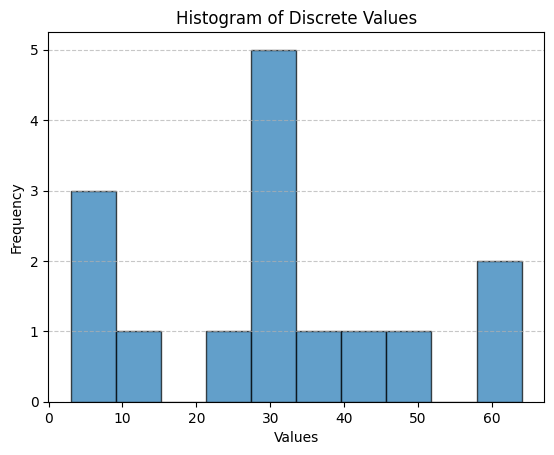

In [312]:
i += 1
data = neighbor_class_distribution[i, :]

plt.hist(data, edgecolor='black', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Discrete Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [314]:
def eval(sample):
    true_label = adf.iloc[X_test_i].iloc[sample].type
    descr = adf.iloc[X_test_i].iloc[sample].descr
    text = ''
    
    df_entry = df[df.descr == descr]
    if df_entry.shape[0]:
        text = [(" ").join(x) for x in (df_entry.sentences.item())]
        
    print("For sample ", sample, ":")
    print("With true label: ", true_label)
    print("Relation: ", descr)
    
    
    unique_elements, counts = np.unique(neighbor_class_distribution[sample, :], return_counts=True)
    shares = counts / len(neighbor_class_distribution[sample, :])
    table = np.column_stack((unique_elements, counts, shares))
    sorted_table = table[table[:, 1].argsort()[::-1]]
    print("Element\tCount\tShare")
    for row in sorted_table:
        print(f"{int(row[0])}\t{int(row[1])}\t{row[2]:.2%}")

        
    print("\n\n Neighbors:\n")
    for neighbor in neigh_ind[sample, :]:
        n_label = adf.iloc[X_train_i].iloc[neighbor].type
        n_descr = adf.iloc[X_train_i].iloc[neighbor].descr
    
        print(n_label, " : ", n_descr)
        
        
    
    print("\n\n Original text ", text)
    

In [318]:
sample = 239

In [394]:
sample += 1
eval(sample)

For sample  315 :
With true label:  26
Relation:  Norman Mailer -> spouse -> Norris Church
Element	Count	Share
51	2	13.33%
43	2	13.33%
26	2	13.33%
19	2	13.33%
73	1	6.67%
53	1	6.67%
47	1	6.67%
35	1	6.67%
30	1	6.67%
20	1	6.67%
6	1	6.67%


 Neighbors:

51  :  Stephen King -> notable work -> Dark Tower
43  :  Bob Woodward -> employer -> Washington Post
19  :  Eden Riegel -> sibling -> Sam Riegel
26  :  James Clark -> spouse -> Alda Tyson Hopkins
53  :  Moneypenny Diaries : Guardian Angel -> screenwriter -> Kate Westbrook
26  :  Myrlie Evers-Williams -> spouse -> Medgar Evers
30  :  Leia Organa -> father -> Darth Vader
19  :  Emily -> sibling -> Charlotte Brontë
47  :  Barry C. Barish -> award received -> Nobel Prize in Physics
6  :  Encore -> performer -> Elaine Paige
20  :  Rishi Kapoor -> child -> Ranbir Kapoor
43  :  Thomas Watson -> employer -> IBM
51  :  Harlan Ellison -> notable work -> Deathbird Stories : A Pantheon of Modern Gods
35  :  Marshall Lee -> creator -> Pendleton Ward
73 

## Investigate if the model has any chance to discriminate existing from non-existing relations

In [37]:
df.apply(lambda x: (x['relation_type'],x['relation_name']), axis=1).sort_values().unique()

array([(1, 'country'),
       (2, 'located in the administrative territorial entity'),
       (3, 'country of citizenship'),
       (4, 'contains administrative territorial entity'),
       (5, 'publication date'), (6, 'performer'), (7, 'date of birth'),
       (8, 'date of death'), (9, 'cast member'), (10, 'record label'),
       (11, 'has part'), (12, 'part of'), (13, 'country of origin'),
       (14, 'place of birth'), (15, 'inception'),
       (16, 'member of sports team'), (17, 'member of political party'),
       (18, 'member of'), (19, 'sibling'), (20, 'child'),
       (21, 'continent'), (22, 'author'), (23, 'present in work'),
       (24, 'applies to jurisdiction'), (25, 'educated at'),
       (26, 'spouse'), (27, 'conflict'), (28, 'director'),
       (29, 'headquarters location'), (30, 'father'), (31, 'platform'),
       (32, 'participant of'),
       (33, 'located in or next to body of water'), (34, 'owned by'),
       (35, 'creator'), (36, 'developer'), (37, 'place of death'

In [38]:
df[df.relation_type == 33].apply(lambda x: (x['e1']['type'],x.e2['type']), axis=1).value_counts()

(LOC, LOC)    101
(NUM, LOC)      1
dtype: int64

In [39]:
df[df.relation_type == 2].apply(lambda x: (x['e1']['type'],x.e2['type']), axis=1).value_counts()

(LOC, LOC)     1743
(ORG, LOC)      175
(MISC, LOC)      18
(LOC, ORG)       11
(LOC, MISC)       5
(PER, LOC)        5
(ORG, ORG)        1
(LOC, PER)        1
(PER, ORG)        1
(MISC, ORG)       1
dtype: int64

In [40]:
df[df.relation_type == 1].apply(lambda x: (x['e1']['type'],x.e2['type']), axis=1).value_counts()

(LOC, LOC)      3334
(ORG, LOC)       867
(MISC, LOC)      259
(LOC, MISC)       21
(PER, LOC)        16
(LOC, ORG)        12
(ORG, MISC)       10
(ORG, ORG)         7
(MISC, ORG)        3
(TIME, LOC)        3
(NUM, LOC)         3
(LOC, PER)         1
(MISC, MISC)       1
dtype: int64

In [228]:
docred_rel2id = json.load(open('./rel2id.json', 'r'))
pandas_input = {'sentences': [], 'relation_type': [], 'relation_name': [], 'descr': [], 'e1': [], 'e2': []}

for index in range(len(dataset['train_annotated'])):
    sample = dataset['train_annotated'][index]
    entities = sample['vertexSet']
    
    possible_head_entities = []
    possible_tail_entities = []
    
    for e in entities: 
        if e[0]['type'] == 'LOC':
            possible_head_entities.append(e)
            possible_tail_entities.append(e)

    num_e = len(entities)
    pairings = [(i,j) for i in range(len(possible_head_entities)) for j in range(len(possible_tail_entities)) if possible_head_entities[i] != possible_tail_entities[j]]
        
    # iterate over relationships
    for (i,x) in enumerate(sample['labels']['relation_id']):
        
        label = sample['labels']
        relation_type = int(docred_rel2id[label['relation_id'][i]])
        
        if(relation_type not in [1,2,33]):
            continue;
        
        relation_name = label['relation_text'][i]

        head_entity = label['head'][i]
        tail_entity = label['tail'][i]
        
        if (head_entity,tail_entity) in pairings:
            pairings.remove((head_entity,tail_entity))
            
        if (tail_entity,head_entity) in pairings:
            pairings.remove((tail_entity,head_entity))

        if(len(entities[head_entity]) > 1 or len(entities[tail_entity]) > 1):
            # skip ambigious relations
            continue 

        head_entity = entities[head_entity][0]
        tail_entity = entities[tail_entity][0]
        descr = "".join([head_entity["name"], " -> ", relation_name, " -> ", tail_entity["name"]])
        
        pandas_input['sentences'].append(sample['sents'])
        pandas_input['relation_type'].append(relation_type)
        pandas_input['relation_name'].append(relation_name)
        pandas_input['descr'].append(descr)
        pandas_input['e1'].append(head_entity)
        pandas_input['e2'].append(tail_entity)
        
    for pair in pairings:
#         ind = np.random.choice(len(pairings))
#         pair = pairings[ind]
        
        head_entity = possible_head_entities[pair[0]][0]
        tail_entity = possible_tail_entities[pair[1]][0]
        relation_name = "NONE"
        
        descr = "".join([head_entity["name"], " -> ", relation_name, " -> ", tail_entity["name"]])
        pandas_input['sentences'].append(sample['sents'])
        pandas_input['relation_type'].append(-1)
        pandas_input['relation_name'].append(relation_name)
        pandas_input['descr'].append(descr)
        pandas_input['e1'].append(head_entity)
        pandas_input['e2'].append(tail_entity)


In [229]:
df_none = pd.DataFrame.from_dict(pandas_input)

In [230]:
df_none.relation_type.value_counts()

-1     128224
 1       4537
 2       1961
 33       102
Name: relation_type, dtype: int64

In [231]:
sample_A = df_none[df_none['relation_type'] == -1].sample(n=5000, replace=False)

sample_B = df_none[df_none['relation_type'] == 1].sample(n=100, replace=False)

sample_C = df_none[df_none['relation_type'] == 2].sample(n=100, replace=False)

sample_D = df_none[df_none['relation_type'] == 33].sample(n=100, replace=False)

df_none_f = pd.concat([sample_A, sample_B, sample_C, sample_D], ignore_index=True)


In [232]:
df_none_f.relation_type.value_counts()

-1     5000
 1      100
 2      100
 33     100
Name: relation_type, dtype: int64

In [233]:
analysis_df2 = {'type': [], 'e_emb': [], 'cls_emb': [], 'descr': []}

for index, row in tqdm(df_none_f.iterrows()):
    
    tagged_sentence = " ".join(tag_words(row['sentences'], row['e1'], row['e2']))
    
    tokens = tokenizer(tagged_sentence)
    
    if(len(tokens.input_ids) > 512):
        print("input seq too long")
        continue
    
    emb = pipe(tagged_sentence)

    start_e1 = tokens.input_ids.index(tokenizer.get_added_vocab()['[E1S]'])
    start_e2 = tokens.input_ids.index(tokenizer.get_added_vocab()['[E2S]'])
   
    entity_tags_emb = np.concatenate((np.array(emb[0][start_e1]), np.array(emb[0][start_e2])))

    cls_emb = np.array(emb[0][0])
    
    analysis_df2['type'].append(row['relation_type'])
    analysis_df2['e_emb'].append(entity_tags_emb)
    analysis_df2['cls_emb'].append(cls_emb)
    analysis_df2['descr'].append(row['descr'])

468it [00:24, 22.21it/s]

input seq too long


516it [00:26, 22.22it/s]

input seq too long


721it [00:36, 21.72it/s]

input seq too long


1410it [01:11, 22.83it/s]

input seq too long


1434it [01:12, 20.52it/s]

input seq too long


1608it [01:21, 20.96it/s]

input seq too long


1628it [01:22, 20.94it/s]

input seq too long


2128it [01:49, 22.15it/s]

input seq too long


2226it [01:54, 20.57it/s]

input seq too long


2676it [02:17, 19.35it/s]

input seq too long


2984it [02:33, 22.37it/s]

input seq too long


3608it [03:06, 20.64it/s]

input seq too long


3884it [03:20, 21.56it/s]

input seq too long


3924it [03:22, 21.78it/s]

input seq too long


3988it [03:25, 21.72it/s]

input seq too long


4182it [03:35, 21.37it/s]

input seq too long


4285it [03:40, 21.71it/s]

input seq too long


4414it [03:47, 22.74it/s]

input seq too long


4656it [03:59, 20.05it/s]

input seq too long


5300it [04:33, 19.41it/s]


In [234]:
adf2 = pd.DataFrame.from_dict(analysis_df2)

reducer = umap.UMAP()
embedding = reducer.fit_transform([e.tolist() for e in adf2.e_emb])

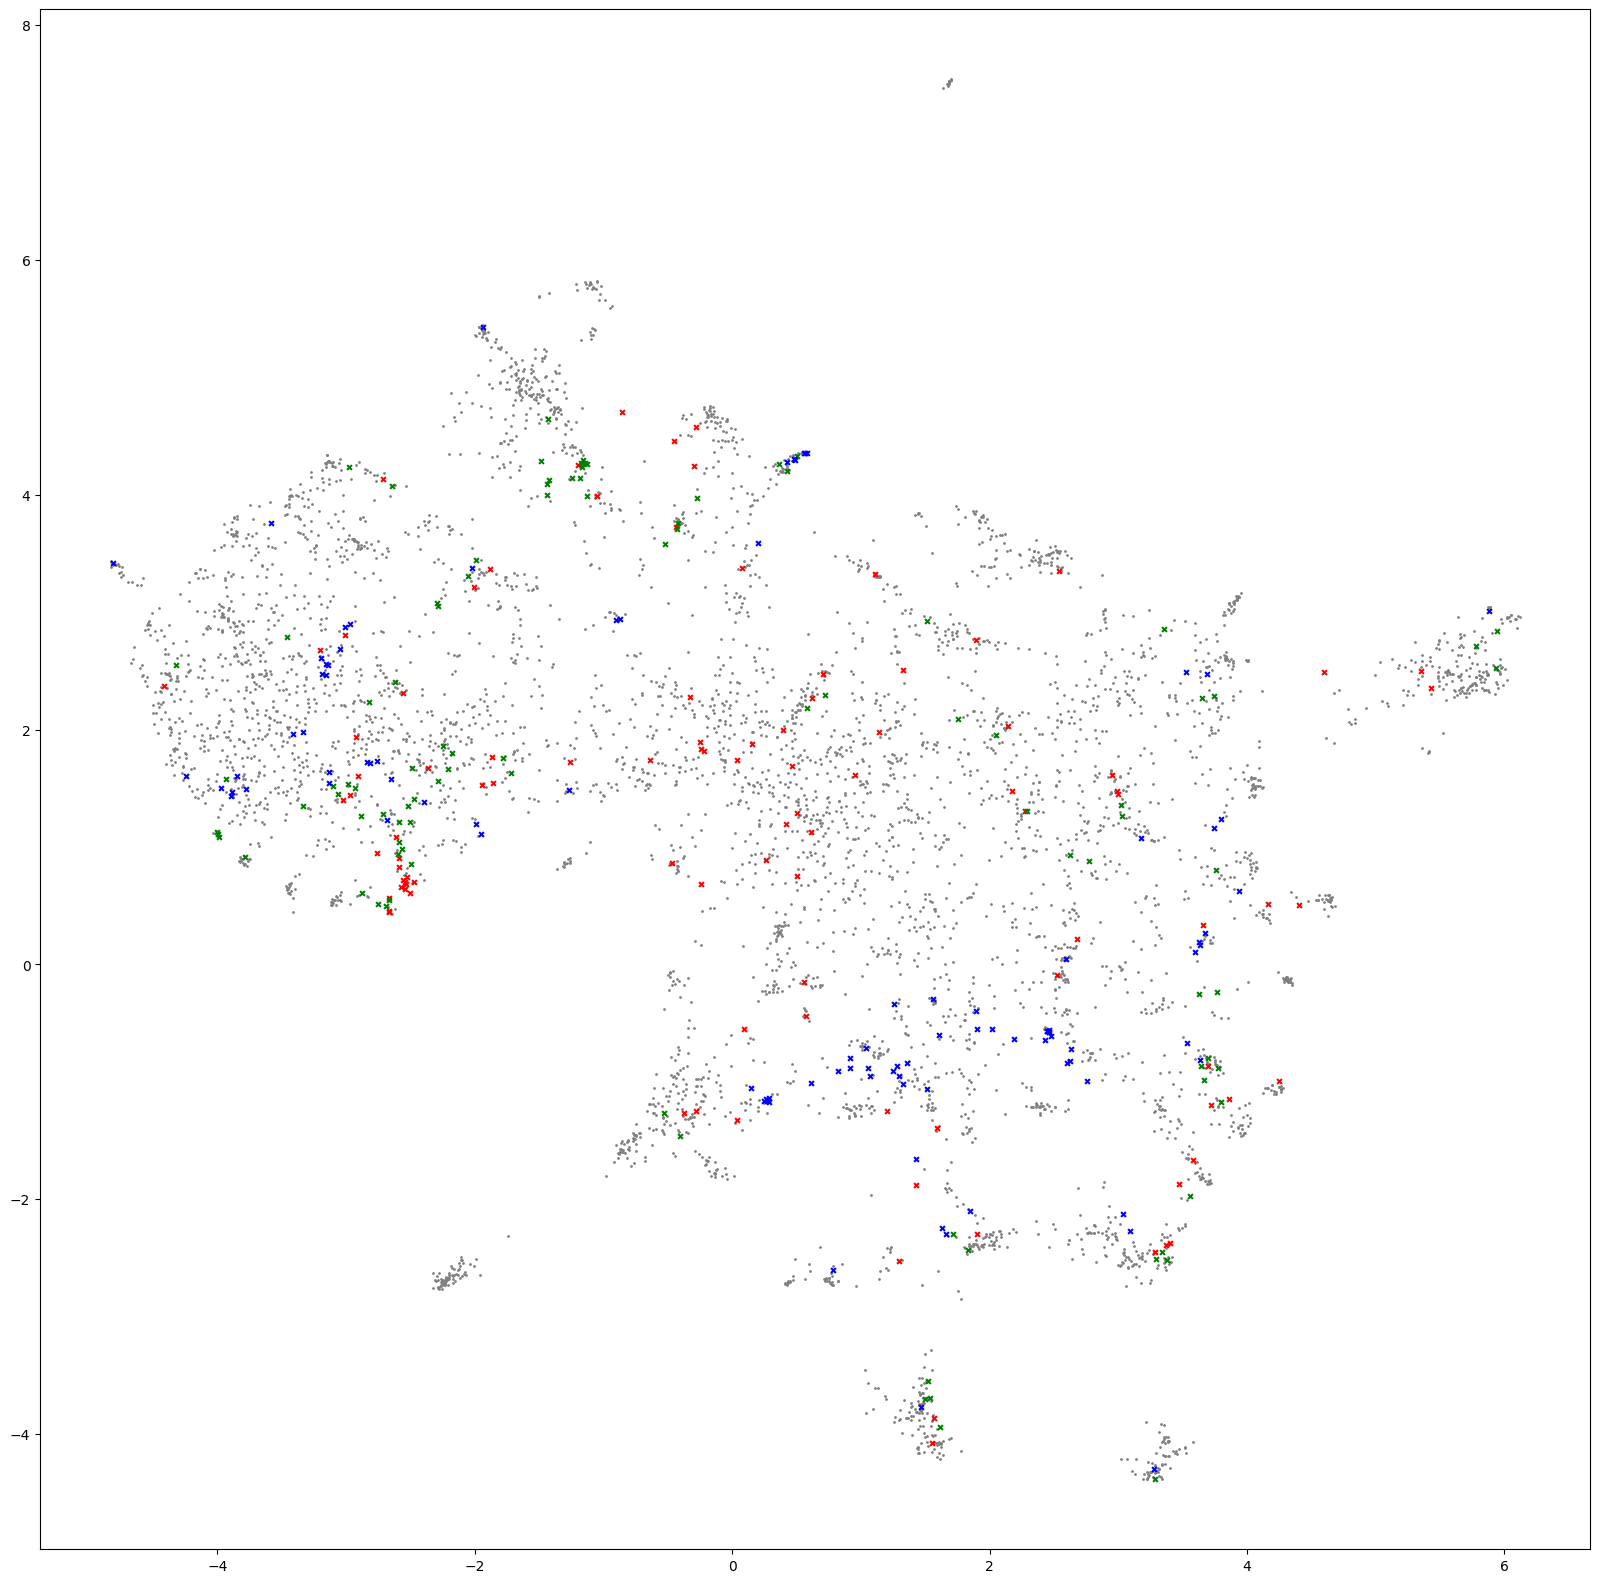

In [48]:
markers = {
    -1: 'o',
    1: 'x',
    2: 'x',
    33: 'x',
}

size = {
    -1: 1,
    1: 12,
    2: 12,
    33: 12,
}

colors = {
    -1: 'gray',
    1: 'red',
    2: 'green',
    33: 'blue',
}

ms = [markers[x] for x in adf2['type']]
colors = [colors[x] for x in adf2['type']]
sizes = [size[x] for x in adf2['type']]

plt.figure(figsize=(20, 20))

for i in range(len(adf2)):
    plt.scatter(
        embedding[i, 0],
        embedding[i, 1],
        s=sizes[i],
        marker=ms[i],
        c=colors[i]
    )
plt.savefig('b.pdf')
plt.show()

In [51]:
import plotly.express as px
adf2["type"] = adf2["type"].astype(str)

fig = px.scatter(adf2, x=embedding[:, 0], y=embedding[:, 1], color='type', hover_data={'descr': True})
fig.update_traces(marker=dict(size=3))
fig.show()


In [52]:
fig.write_html("recall.html")

## Diff

In [53]:
adf2['difference'] = adf2.apply(lambda r: r.e_emb[:768] - r.e_emb[768:], axis = 1)

In [54]:
adf2.difference

0       [0.23491843044757843, -0.19365272670984268, 0....
1       [0.2892242930829525, -0.4972321353852749, 0.17...
2       [-0.19233232736587524, 0.03959878534078598, 0....
3       [0.18411825597286224, -0.1988929808139801, -0....
4       [-0.246698796749115, -0.1582295298576355, 0.15...
                              ...                        
5269    [0.2181982696056366, -0.19773798435926437, 0.3...
5270    [0.25663404166698456, -0.3610570728778839, 0.2...
5271    [0.29486361145973206, -0.07533121109008789, -0...
5272    [0.4541676342487335, 0.189749825745821, 0.1337...
5273    [0.20009709894657135, 0.4579375386238098, -0.2...
Name: difference, Length: 5274, dtype: object

In [55]:
reducer = umap.UMAP()
embedding = reducer.fit_transform([e.tolist() for e in adf2.difference])

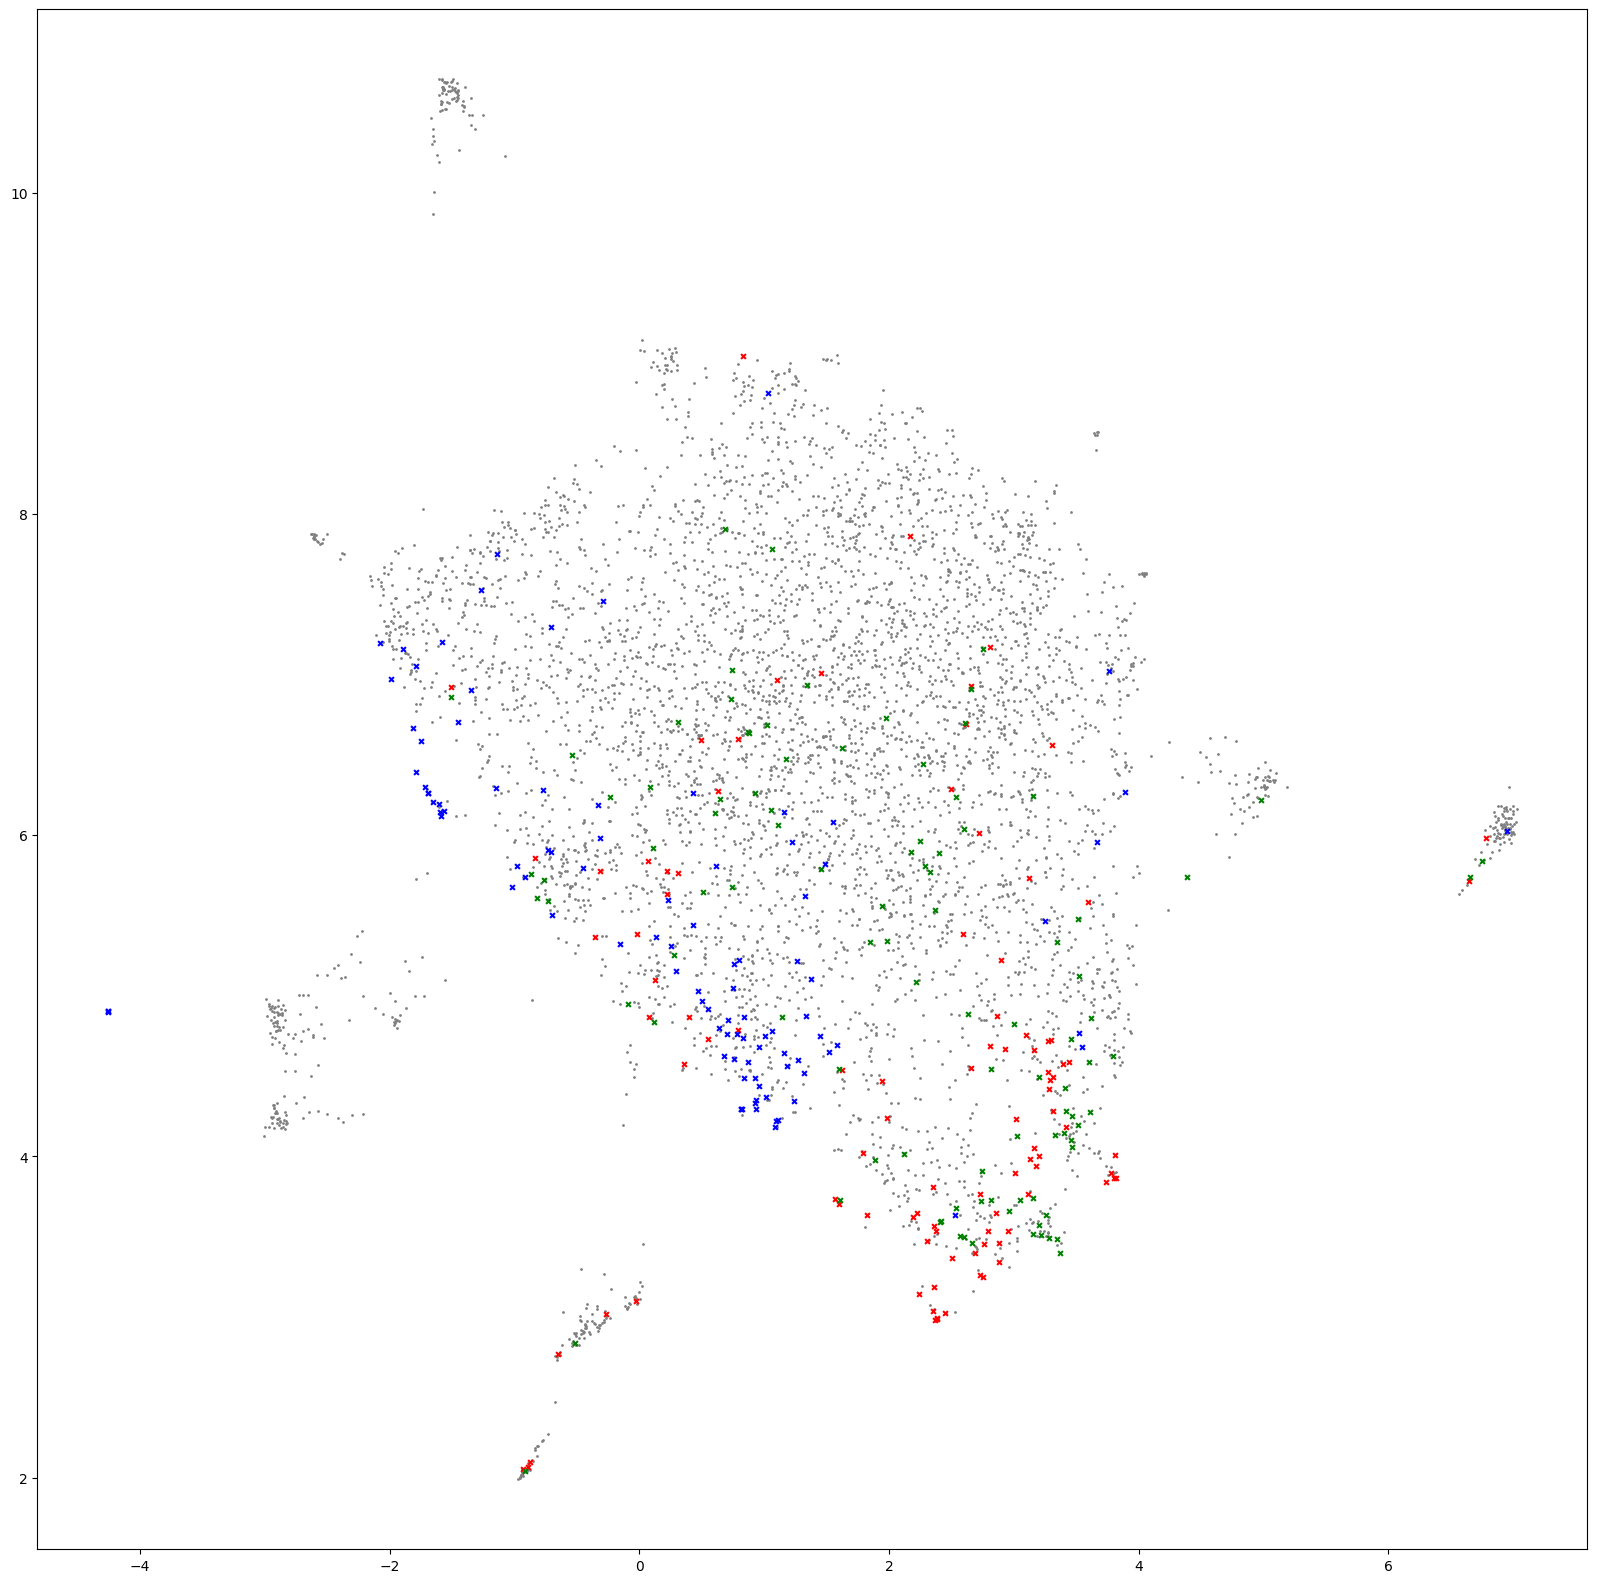

In [87]:
markers = {
    -1: 'o',
    1: 'x',
    2: 'x',
    33: 'x',
}

size = {
    -1: 1,
    1: 12,
    2: 12,
    33: 12,
}

colors = {
    -1: 'gray',
    1: 'red',
    2: 'green',
    33: 'blue',
}

ms = [markers[x] for x in adf2['type']]
colors = [colors[x] for x in adf2['type']]
sizes = [size[x] for x in adf2['type']]

plt.figure(figsize=(20, 20))

for i in range(len(adf2)):
    plt.scatter(
        embedding[i, 0],
        embedding[i, 1],
        s=sizes[i],
        marker=ms[i],
        c=colors[i]
    )
plt.savefig('b2.pdf')
plt.show()

In [56]:
import plotly.express as px
adf2["type"] = adf2["type"].astype(str)

fig = px.scatter(adf2, x=embedding[:, 0], y=embedding[:, 1], color='type', hover_data={'descr': True})
fig.update_traces(marker=dict(size=3))
fig.show()

In [57]:
fig.write_html("diff.html")

## Let's see general accuracy

In [97]:
type( adf.e_emb[0])

numpy.ndarray

In [100]:
adf['difference'] = adf.apply(lambda r: r.e_emb[:768] - r.e_emb[768:], axis = 1)
adf['both'] = adf.apply(lambda r: np.concatenate((r.e_emb,r.difference), axis =0), axis = 1)

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = adf['e_emb'].values
y = adf['type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train.tolist(), y_train)

y_pred = knn_classifier.predict(X_test.tolist())

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

class_report = classification_report(y_test, y_pred, output_dict=True)


Accuracy: 49.73%


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = adf['difference'].values
y = adf['type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=42)

knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train.tolist(), y_train)

y_pred = knn_classifier.predict(X_test.tolist())

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

class_report = classification_report(y_test, y_pred, output_dict=True)


Accuracy: 37.05%


The accuracy drops now, but this makes sense! 

We lose the information about the entity types!

But hmm, does the same idea work if it's not LOC - LOC but other entities?

## Redo for different entity pairs

In [70]:
(16, 'member of sports team')
(17, 'member of political party')
(18, 'member of')

(18, 'member of')

In [73]:
adf[df.relation_type ==18].apply(lambda x: (x['e1']['type'],x.e2['type']), axis=1).value_counts()

(PER, ORG)     82
(LOC, ORG)     24
(LOC, LOC)      3
(PER, MISC)     2
(PER, PER)      1
(MISC, ORG)     1
(PER, LOC)      1
(ORG, LOC)      1
(ORG, ORG)      1
dtype: int64

In [75]:
docred_rel2id = json.load(open('./rel2id.json', 'r'))
pandas_input = {'sentences': [], 'relation_type': [], 'relation_name': [], 'descr': [], 'e1': [], 'e2': []}

for index in range(len(dataset['train_annotated'])):
    sample = dataset['train_annotated'][index]
    entities = sample['vertexSet']
    
    possible_head_entities = []
    possible_tail_entities = []
    
    for e in entities: 
        if e[0]['type'] == 'PER':
            possible_head_entities.append(e)
        if e[0]['type'] == 'ORG':
            possible_tail_entities.append(e)

    pairings = [(i,j) for i in range(len(possible_head_entities)) for j in range(len(possible_tail_entities)) if possible_head_entities[i] != possible_tail_entities[j]]
        
    # iterate over relationships
    for (i,x) in enumerate(sample['labels']['relation_id']):
        
        label = sample['labels']
        relation_type = int(docred_rel2id[label['relation_id'][i]])
        
        if(relation_type not in [16,17,18]):
            continue;
        
        relation_name = label['relation_text'][i]

        head_entity = label['head'][i]
        tail_entity = label['tail'][i]
        
        if (head_entity,tail_entity) in pairings:
            pairings.remove((head_entity,tail_entity))

        if(len(entities[head_entity]) > 1 or len(entities[tail_entity]) > 1):
            # skip ambigious relations
            continue 

        head_entity = entities[head_entity][0]
        tail_entity = entities[tail_entity][0]
        descr = "".join([head_entity["name"], " -> ", relation_name, " -> ", tail_entity["name"]])
        
        pandas_input['sentences'].append(sample['sents'])
        pandas_input['relation_type'].append(relation_type)
        pandas_input['relation_name'].append(relation_name)
        pandas_input['descr'].append(descr)
        pandas_input['e1'].append(head_entity)
        pandas_input['e2'].append(tail_entity)
        
    for pair in pairings:
        
        head_entity = possible_head_entities[pair[0]][0]
        tail_entity = possible_tail_entities[pair[1]][0]
        relation_name = "NONE"
        
        descr = "".join([head_entity["name"], " -> ", relation_name, " -> ", tail_entity["name"]])
        pandas_input['sentences'].append(sample['sents'])
        pandas_input['relation_type'].append(-1)
        pandas_input['relation_name'].append(relation_name)
        pandas_input['descr'].append(descr)
        pandas_input['e1'].append(head_entity)
        pandas_input['e2'].append(tail_entity)


IndexError: list index out of range

In [ ]:
df_none = pd.DataFrame.from_dict(pandas_input)

## Train prototypes

In [17]:
import torch
from torch import nn

class ProtoSimModel(nn.Module):
    
    def __init__(self, relation_count, embedding_width):
        nn.Module.__init__(self)
        self.prototypes = nn.Embedding(relation_count, embedding_width)
        self.classification_layer = nn.Linear(embedding_width, relation_count)

    
    def forward(self, relation_embedding, relation_id):
        protos = self.prototypes(relation_id)
        similarity = 1 - 1 / (1 + torch.exp((torch.sum(protos * relation_embedding, 1) - 384) / 100)) # scale the value to avoid gradient explosion
        predict_relation = self.classification_layer(protos)
        return similarity, predict_relation

In [86]:
rels = adf['type'].astype(int).unique()
rels.sort()
num_rels = rels.shape[0]

In [95]:
relation_to_index = {rel: index for index, rel in enumerate(rels)}
adf['type_index'] = adf['type'].astype(int).apply(lambda x: relation_to_index[x])

In [108]:
proto_sim_model = ProtoSimModel(num_rels, 1536)
cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(proto_sim_model.parameters(), lr=0.01)
losses = []

embedding_size = 1536

# why?
reversed_index = list(range(48))
reversed_index.reverse()

for epoch in tqdm(range(200)):
    for i in np.random.choice(adf.type_index.unique(), adf.type_index.unique().shape[0]):
        selected_samples_specific = adf[adf['type_index'] == i].sample(n=48, replace=False)
        other_types = adf[adf['type_index'] != i].sample(n=48, replace=False)

        pos_samples = torch.tensor(np.array(selected_samples_specific['e_emb'].tolist()))
        neg_samples = torch.tensor(np.array(other_types['e_emb'].tolist()))
        labels = torch.tensor(np.array(selected_samples_specific['type_index'].tolist()))

        optimizer.zero_grad()
        p_similarity, p_predict_relation = proto_sim_model(pos_samples, labels)
        n_similarity, n_predict_relation = proto_sim_model(neg_samples, labels)

        cluster_loss = -(torch.mean(torch.log(p_similarity + 1e-5)) + torch.mean(torch.log(1-n_similarity + 1e-5)))
        cls_loss = torch.mean(cross_entropy(p_predict_relation, labels) + cross_entropy(n_predict_relation, labels)) * 0.5


        repeat_time, embedding_size = neg_samples.shape
        repeat_n_rel_emb = neg_samples.repeat(repeat_time, 1).view(repeat_time, repeat_time, embedding_size)
        repeat_p_rel_emb = pos_samples.repeat(1, repeat_time).view(repeat_time, repeat_time, embedding_size)
        negative_part = torch.sum(repeat_p_rel_emb * repeat_n_rel_emb, -1) / 100 # (batch_size, sample_size)
        reversed_p_relation_embedding = torch.index_select(pos_samples.view(1, -1, embedding_size), 1, torch.tensor(reversed_index)).view(-1, embedding_size)
        positive_part = torch.sum(pos_samples * reversed_p_relation_embedding, -1) / 100
        max_val = torch.max(torch.max(positive_part), torch.max(negative_part))
        cp_loss = -torch.log(torch.exp(positive_part - max_val) / (torch.exp(positive_part - max_val) + torch.sum(torch.exp(negative_part - max_val), -1)) + 1e-5)
        cp_loss = torch.mean(cp_loss)

        loss = 0.5 * cluster_loss + 0.5 * cls_loss + cp_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:23<00:00,  2.41it/s]


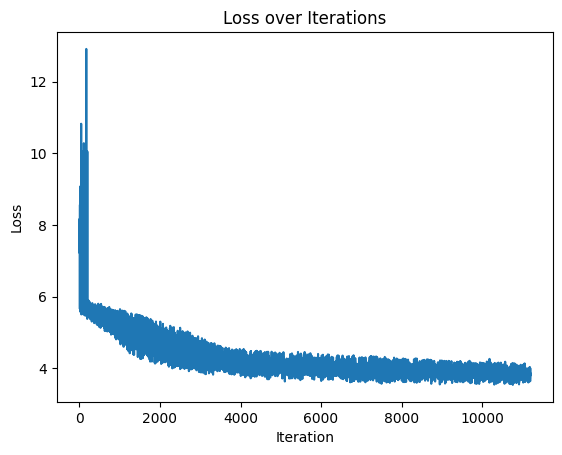

In [110]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()


In [111]:
trained_prototypes = proto_sim_model.prototypes.weight.detach().numpy()

In [112]:
reducer = umap.UMAP()
embedding = reducer.fit_transform([e.tolist() for e in adf.e_emb] + [e.tolist() for e in trained_prototypes])
embedding.shape

(2847, 2)

In [113]:
adf["type_index"].unique()

array([23, 21, 43,  8, 19, 25,  3, 20,  0,  2, 12, 33,  6,  7, 34, 26, 40,
       28, 42, 36, 55, 10, 39, 27, 14, 52, 35, 37, 44, 31,  1, 41, 17, 16,
       15, 47, 51, 48, 32, 11, 38, 30,  5, 13, 29, 54, 22,  4, 45,  9, 46,
       49, 50, 18, 24, 53])

In [114]:
adf["type"] = adf["type"].astype(str)

import plotly.express as px

x=embedding[:, 0]
y=embedding[:, 1] 
color= np.array( adf['type_index'].tolist() + list(range(len(trained_prototypes)))).astype(str)
hover_data = np.array(adf['descr'].tolist() + ['prototype' + str(i) for i in range(len(trained_prototypes))])
p = np.array([False]* len(adf) + [True] * len(trained_prototypes))


df_with_proto = pd.DataFrame({'x': x, 'y': y, 'color': color, 'hover_data': hover_data, 'p': p})
df_with_proto['msize'] = df_with_proto.apply(lambda r: 10 if r.p else 1, axis = 1)

fig = px.scatter(df_with_proto, x='x', y='y', color='color', hover_data = 'hover_data', size='msize')
fig.update_traces()


In [115]:
fig.write_html("trained_prototypes.html")

### How well does classification work?

In [118]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets, with 50% in each set
train_df, test_df = train_test_split(adf, test_size=0.5, stratify=adf['type_index'], random_state=42)


In [123]:
proto_sim_model = ProtoSimModel(num_rels, 1536)
cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(proto_sim_model.parameters(), lr=0.01)
losses = []

embedding_size = 1536

# why?
reversed_index = list(range(24))
reversed_index.reverse()

for epoch in tqdm(range(200)):
    for i in np.random.choice(train_df.type_index.unique(), train_df.type_index.unique().shape[0]):
        selected_samples_specific = train_df[train_df['type_index'] == i].sample(n=24, replace=False)
        other_types = train_df[train_df['type_index'] != i].sample(n=24, replace=False)

        pos_samples = torch.tensor(np.array(selected_samples_specific['e_emb'].tolist()))
        neg_samples = torch.tensor(np.array(other_types['e_emb'].tolist()))
        labels = torch.tensor(np.array(selected_samples_specific['type_index'].tolist()))

        optimizer.zero_grad()
        p_similarity, p_predict_relation = proto_sim_model(pos_samples, labels)
        n_similarity, n_predict_relation = proto_sim_model(neg_samples, labels)

        cluster_loss = -(torch.mean(torch.log(p_similarity + 1e-5)) + torch.mean(torch.log(1-n_similarity + 1e-5)))
        cls_loss = torch.mean(cross_entropy(p_predict_relation, labels) + cross_entropy(n_predict_relation, labels)) * 0.5


        repeat_time, embedding_size = neg_samples.shape
        repeat_n_rel_emb = neg_samples.repeat(repeat_time, 1).view(repeat_time, repeat_time, embedding_size)
        repeat_p_rel_emb = pos_samples.repeat(1, repeat_time).view(repeat_time, repeat_time, embedding_size)
        negative_part = torch.sum(repeat_p_rel_emb * repeat_n_rel_emb, -1) / 100 # (batch_size, sample_size)
        reversed_p_relation_embedding = torch.index_select(pos_samples.view(1, -1, embedding_size), 1, torch.tensor(reversed_index)).view(-1, embedding_size)
        positive_part = torch.sum(pos_samples * reversed_p_relation_embedding, -1) / 100
        max_val = torch.max(torch.max(positive_part), torch.max(negative_part))
        cp_loss = -torch.log(torch.exp(positive_part - max_val) / (torch.exp(positive_part - max_val) + torch.sum(torch.exp(negative_part - max_val), -1)) + 1e-5)
        cp_loss = torch.mean(cp_loss)

        loss = 0.5 * cluster_loss + 0.5 * cls_loss + cp_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:54<00:00,  3.67it/s]


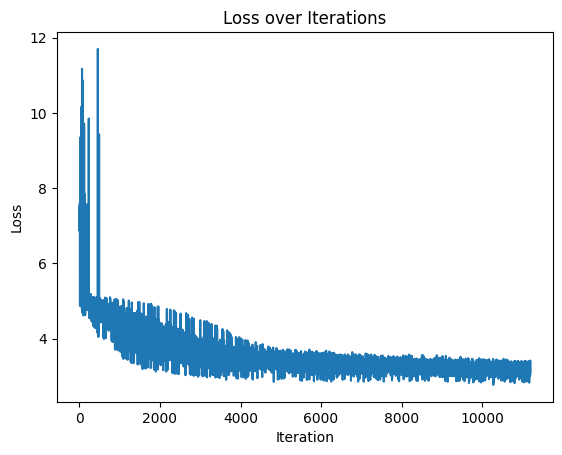

In [159]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

In [160]:
trained_prototypes

array([[ -1.3758818 ,   0.4000877 ,  -3.0319679 , ...,  -3.1295767 ,
          0.37207735,  -7.113998  ],
       [  1.0317385 ,  -2.8406782 ,   1.9102653 , ...,  -1.5071479 ,
         -0.17264694,  -2.623601  ],
       [  4.3081346 ,   5.256862  ,   2.1421273 , ...,  -5.4140973 ,
          0.30577394,  -6.8825974 ],
       ...,
       [ -6.4840136 ,  -3.9934986 ,  -2.0884798 , ...,  -0.40884185,
          4.8570023 ,   3.7319283 ],
       [ -0.1466282 ,  -6.046256  ,  -9.483497  , ..., -10.537816  ,
          2.417575  ,   5.0755844 ],
       [  5.4735904 ,   1.6963359 ,   1.6282532 , ...,  -4.2114053 ,
         -2.7634923 ,  -4.8956175 ]], dtype=float32)

In [179]:
[e for e in test_df['e_emb']]

[array([ 0.44253239,  0.23359364, -0.15085332, ...,  0.02670657,
        -0.09718984, -0.46945959]),
 array([0.30175853, 0.36698404, 0.12035441, ..., 0.05010238, 0.056733  ,
        0.32090232]),
 array([-0.33321011,  0.25238657, -0.07330623, ..., -0.03179371,
         0.28393608, -0.0633904 ]),
 array([-0.47491431,  0.03493553,  0.23060441, ...,  0.31337833,
         0.09560092,  0.1938618 ]),
 array([-0.47809377,  0.07462624,  0.22093304, ..., -0.03922114,
         0.25912386,  0.08751706]),
 array([-0.07816266,  0.3591235 ,  0.14862025, ...,  0.12968451,
         0.17893018, -0.0204941 ]),
 array([-0.04895872,  0.10007713, -0.10439999, ..., -0.12036958,
        -0.17949665, -0.00443067]),
 array([ 0.0688524 ,  0.1651901 ,  0.45472366, ...,  0.07114466,
        -0.17699033,  0.1885037 ]),
 array([-0.27869964, -0.31668338, -0.08720328, ..., -0.32306513,
         0.07405003, -0.12117877]),
 array([-0.10961945, -0.04036822,  0.38468242, ...,  0.27997357,
        -0.07494478, -0.37616748

In [184]:
trained_prototypes

array([[ -1.3758818 ,   0.4000877 ,  -3.0319679 , ...,  -3.1295767 ,
          0.37207735,  -7.113998  ],
       [  1.0317385 ,  -2.8406782 ,   1.9102653 , ...,  -1.5071479 ,
         -0.17264694,  -2.623601  ],
       [  4.3081346 ,   5.256862  ,   2.1421273 , ...,  -5.4140973 ,
          0.30577394,  -6.8825974 ],
       ...,
       [ -6.4840136 ,  -3.9934986 ,  -2.0884798 , ...,  -0.40884185,
          4.8570023 ,   3.7319283 ],
       [ -0.1466282 ,  -6.046256  ,  -9.483497  , ..., -10.537816  ,
          2.417575  ,   5.0755844 ],
       [  5.4735904 ,   1.6963359 ,   1.6282532 , ...,  -4.2114053 ,
         -2.7634923 ,  -4.8956175 ]], dtype=float32)

In [187]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KDTree

trained_prototypes = proto_sim_model.prototypes.weight.detach().numpy()

kdt = KDTree(trained_prototypes, leaf_size=1)
kdt.query([e for e in train_df['e_emb']], k=1, return_distance=False)

# knn_classifier = KNeighborsClassifier(n_neighbors=1)  # You can adjust the number of neighbors
# knn_classifier.fit([e for e in trained_prototypes], list(range(len(trained_prototypes))))

# y_pred = knn_classifier.predict([e for e in test_df['e_emb']])

# accuracy = accuracy_score(test_df['type_index'].tolist(), y_pred)

# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(y_pred.shape)
# print(np.unique(y_pred))


array([[53],
       [53],
       [53],
       ...,
       [53],
       [53],
       [53]])

In [190]:
a = [e for e in test_df['e_emb']][0]
b = trained_prototypes[0]

In [210]:
train_df

type                                              e_emb  \
1675   17  [0.18988151848316193, -0.02548733726143837, -0...   
2167   14  [-0.2758600115776062, 0.6923485398292542, 0.50...   
74     22  [-0.2403729259967804, 0.44384485483169556, -0....   
967    39  [-0.23548650741577148, 0.06996768712997437, -0...   
2243   31  [-0.2770724892616272, 0.03007389046251774, 0.5...   
...   ...                                                ...   
594    35  [-0.10681886970996857, 0.19617585837841034, 0....   
2505   50  [-0.4950767159461975, 0.4562484920024872, 0.15...   
242    20  [-0.2671431005001068, -0.14852111041545868, 0....   
1858   52  [-0.1821669638156891, -0.3652247190475464, 0.5...   
2348    5  [0.06635385751724243, 0.15610367059707642, 0.1...   

                                                cls_emb  \
1675  [-0.1006530225276947, 0.08370564877986908, -0....   
2167  [-0.2085048407316208, 0.3413504958152771, -0.2...   
74    [-0.18617995083332062, -0.14699141681194305, -...   
967   [-0.14444372057914734, -0.4052935838699341, -0...   
2243  [-0.5989630222320557, -0.3837850093841553, 0.0...   
...                                                 ...   
594   [-0.035523898899555206, -0.49526190757751465, ...   
2505  [-0.34524428844451904, 0.09905680269002914, -0...   
242   [-0.801051914691925, -0.6620640754699707, -0.2...   
1858  [-0.16672347486019135, -0.10261969268321991, -...   
2348  [-0.03317442163825035, -0.41869497299194336, -...   

                                                  descr  type_index  
1675  Edi Rama -> member of political party -> Socia...          16  
2167  Franz Josef Niedenzu -> place of birth -> Köpp...          13  
74    Of Women and Their Elegance -> author -> Norma...          21  
967    A Storm of Swords -> follows -> A Clash of Kings          36  
2243  Soldier Blade -> platform -> PlayStation Portable          29  
...                                                 ...         ...  
594                Mr. Hankey -> creator -> Trey Parker          33  
2505                  Jean Calvin -> religion -> Jewish          46  
242           Hail To Reason -> child -> Stop The Music          19  
1858        Independent Lens -> original network -> PBS          48  
2348  Virus of the Mind -> publication date -> Decem...           4  

[1395 rows x 5 columns]

In [214]:
pred = []
labels = []

for i in range(len(test_df)):
    a = [e for e in test_df['e_emb']][i]
    true_label = [e for e in test_df['type_index']][i]
    labels.append(true_label)
    pred.append((a * trained_prototypes).sum(axis=1).argmax())

accuracy = accuracy_score(labels, pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 71.92%


In [226]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X_train = train_df['e_emb'].values
y_train = train_df['type_index'].values
X_test = test_df['e_emb'].values
y_test = test_df['type_index'].values

knn_classifier = KNeighborsClassifier(n_neighbors=40)  # You can adjust the number of neighbors
knn_classifier.fit(X_train.tolist(), y_train)

y_pred = knn_classifier.predict(X_test.tolist())

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

class_report = classification_report(y_test, y_pred, output_dict=True)


Accuracy: 58.02%


In [189]:
reducer = umap.UMAP()
embedding = reducer.fit_transform([e.tolist() for e in test_df.e_emb] + [e.tolist() for e in trained_prototypes])
embedding.shape

test_df["type"] = test_df["type"].astype(str)

import plotly.express as px

x=embedding[:, 0]
y=embedding[:, 1] 
color= np.array( test_df['type_index'].tolist() + list(range(len(trained_prototypes)))).astype(str)
hover_data = np.array(test_df['descr'].tolist() + ['prototype' + str(i) for i in range(len(trained_prototypes))])
p = np.array([False]* len(test_df) + [True] * len(trained_prototypes))


df_with_proto = pd.DataFrame({'x': x, 'y': y, 'color': color, 'hover_data': hover_data, 'p': p})
df_with_proto['msize'] = df_with_proto.apply(lambda r: 10 if r.p else 1, axis = 1)

fig = px.scatter(df_with_proto, x='x', y='y', color='color', hover_data = 'hover_data', size='msize')
fig.update_traces()

## Repeat for no relation

In [235]:
adf2

type                                              e_emb  \
0       -1  [-0.1551377922296524, 0.24665378034114838, 0.0...   
1       -1  [-0.19548670947551727, 0.055779829621315, -0.0...   
2       -1  [-0.12454094737768173, -0.12183180451393127, 0...   
3       -1  [-0.6224732995033264, -0.10139987617731094, 0....   
4       -1  [-0.21467798948287964, 0.027208084240555763, 0...   
...    ...                                                ...   
5276    33  [-0.41967257857322693, -0.20311471819877625, 0...   
5277    33  [-0.5867608785629272, -0.07029197365045547, 0....   
5278    33  [-0.40827763080596924, 0.02575613744556904, -0...   
5279    33  [-0.1489761769771576, 0.2689472734928131, -0.1...   
5280    33  [-0.1373571753501892, 0.47374770045280457, 0.1...   

                                                cls_emb  \
0     [-0.19330531358718872, 0.05780607461929321, -0...   
1     [-0.3029870092868805, 0.0774473175406456, -0.0...   
2     [-0.29264509677886963, -0.010118475183844566, ...   
3     [-0.27870357036590576, -0.20111191272735596, 0...   
4     [-0.15024998784065247, 0.37976571917533875, -0...   
...                                                 ...   
5276  [-0.4629603922367096, -0.35845401883125305, -0...   
5277  [-0.4735856354236603, -0.18544457852840424, -0...   
5278  [-0.17189550399780273, -0.047093190252780914, ...   
5279  [-0.2790234088897705, -0.1162007749080658, -0....   
5280  [-0.026288840919733047, -0.02501070871949196, ...   

                                                  descr  
0                          Staulen -> NONE -> Alstahaug  
1                 Clifford Bay -> NONE -> Cape Campbell  
2                      Vithura -> NONE -> Agastyakoodam  
3                     Midland Main Line -> NONE -> A453  
4                 Bendorf bei Koblenz -> NONE -> German  
...                                                 ...  
5276  Charleston -> located in or next to body of wa...  
5277  Virginia Beach -> located in or next to body o...  
5278  Illinois -> located in or next to body of wate...  
5279  Kephalonia -> located in or next to body of wa...  
5280  Phnom Penh -> located in or next to body of wa...  

[5281 rows x 4 columns]

In [248]:
lookup =  {'-1': 0, '1': 1, '2': 2, '33': 3}
adf2['type_index'] = adf2['type'].astype(str).apply((lambda x: lookup[x]))

In [249]:
adf2

type                                              e_emb  \
0       -1  [-0.1551377922296524, 0.24665378034114838, 0.0...   
1       -1  [-0.19548670947551727, 0.055779829621315, -0.0...   
2       -1  [-0.12454094737768173, -0.12183180451393127, 0...   
3       -1  [-0.6224732995033264, -0.10139987617731094, 0....   
4       -1  [-0.21467798948287964, 0.027208084240555763, 0...   
...    ...                                                ...   
5276    33  [-0.41967257857322693, -0.20311471819877625, 0...   
5277    33  [-0.5867608785629272, -0.07029197365045547, 0....   
5278    33  [-0.40827763080596924, 0.02575613744556904, -0...   
5279    33  [-0.1489761769771576, 0.2689472734928131, -0.1...   
5280    33  [-0.1373571753501892, 0.47374770045280457, 0.1...   

                                                cls_emb  \
0     [-0.19330531358718872, 0.05780607461929321, -0...   
1     [-0.3029870092868805, 0.0774473175406456, -0.0...   
2     [-0.29264509677886963, -0.010118475183844566, ...   
3     [-0.27870357036590576, -0.20111191272735596, 0...   
4     [-0.15024998784065247, 0.37976571917533875, -0...   
...                                                 ...   
5276  [-0.4629603922367096, -0.35845401883125305, -0...   
5277  [-0.4735856354236603, -0.18544457852840424, -0...   
5278  [-0.17189550399780273, -0.047093190252780914, ...   
5279  [-0.2790234088897705, -0.1162007749080658, -0....   
5280  [-0.026288840919733047, -0.02501070871949196, ...   

                                                  descr  type_index  
0                          Staulen -> NONE -> Alstahaug           0  
1                 Clifford Bay -> NONE -> Cape Campbell           0  
2                      Vithura -> NONE -> Agastyakoodam           0  
3                     Midland Main Line -> NONE -> A453           0  
4                 Bendorf bei Koblenz -> NONE -> German           0  
...                                                 ...         ...  
5276  Charleston -> located in or next to body of wa...           3  
5277  Virginia Beach -> located in or next to body o...           3  
5278  Illinois -> located in or next to body of wate...           3  
5279  Kephalonia -> located in or next to body of wa...           3  
5280  Phnom Penh -> located in or next to body of wa...           3  

[5281 rows x 5 columns]

In [252]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets, with 50% in each set
train_df, test_df = train_test_split(adf2, test_size=0.5, stratify=adf2['type'], random_state=42)
num_rels = 4 # train 10 for NOTA

In [253]:
proto_sim_model = ProtoSimModel(num_rels, 1536)
cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(proto_sim_model.parameters(), lr=0.01)
losses = []

embedding_size = 1536

# why?
reversed_index = list(range(24))
reversed_index.reverse()

for epoch in tqdm(range(200)):
    for i in np.random.choice(train_df.type_index.unique(), train_df.type_index.unique().shape[0]):
        selected_samples_specific = train_df[train_df['type_index'] == i].sample(n=24, replace=False)
        other_types = train_df[train_df['type_index'] != i].sample(n=24, replace=False)

        pos_samples = torch.tensor(np.array(selected_samples_specific['e_emb'].tolist()))
        neg_samples = torch.tensor(np.array(other_types['e_emb'].tolist()))
        labels = torch.tensor(np.array(selected_samples_specific['type_index'].tolist()))

        optimizer.zero_grad()
        p_similarity, p_predict_relation = proto_sim_model(pos_samples, labels)
        n_similarity, n_predict_relation = proto_sim_model(neg_samples, labels)

        cluster_loss = -(torch.mean(torch.log(p_similarity + 1e-5)) + torch.mean(torch.log(1-n_similarity + 1e-5)))
        cls_loss = torch.mean(cross_entropy(p_predict_relation, labels) + cross_entropy(n_predict_relation, labels)) * 0.5


        repeat_time, embedding_size = neg_samples.shape
        repeat_n_rel_emb = neg_samples.repeat(repeat_time, 1).view(repeat_time, repeat_time, embedding_size)
        repeat_p_rel_emb = pos_samples.repeat(1, repeat_time).view(repeat_time, repeat_time, embedding_size)
        negative_part = torch.sum(repeat_p_rel_emb * repeat_n_rel_emb, -1) / 100 # (batch_size, sample_size)
        reversed_p_relation_embedding = torch.index_select(pos_samples.view(1, -1, embedding_size), 1, torch.tensor(reversed_index)).view(-1, embedding_size)
        positive_part = torch.sum(pos_samples * reversed_p_relation_embedding, -1) / 100
        max_val = torch.max(torch.max(positive_part), torch.max(negative_part))
        cp_loss = -torch.log(torch.exp(positive_part - max_val) / (torch.exp(positive_part - max_val) + torch.sum(torch.exp(negative_part - max_val), -1)) + 1e-5)
        cp_loss = torch.mean(cp_loss)

        loss = 0.5 * cluster_loss + 0.5 * cls_loss + cp_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 65.37it/s]


In [260]:
trained_prototypes = proto_sim_model.prototypes.weight.detach().numpy()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [269]:
pred = []
labels = []

for i in range(len(test_df)):
    a = [e for e in test_df['e_emb']][i]
    true_label = [e for e in test_df['type_index']][i]
    labels.append(true_label)
    pred.append((a * trained_prototypes).sum(axis=1).argmax())

accuracy = accuracy_score(labels, pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

class_report = classification_report(labels, pred, output_dict=True)
class_report

Accuracy: 72.81%


{'0': {'precision': 0.9907407407407407,
  'recall': 0.730228823765556,
  'f1-score': 0.84076727524844,
  'support': 2491},
 '1': {'precision': 0.11813186813186813,
  'recall': 0.86,
  'f1-score': 0.2077294685990338,
  'support': 50},
 '2': {'precision': 0.10135135135135136,
  'recall': 0.3,
  'f1-score': 0.15151515151515152,
  'support': 50},
 '3': {'precision': 0.15699658703071673,
  'recall': 0.92,
  'f1-score': 0.26822157434402333,
  'support': 50},
 'accuracy': 0.7281332828474063,
 'macro avg': {'precision': 0.3418051368136692,
  'recall': 0.702557205941389,
  'f1-score': 0.36705836742666215,
  'support': 2641},
 'weighted avg': {'precision': 0.941597567402833,
  'recall': 0.7281332828474063,
  'f1-score': 0.80489382520514,
  'support': 2641}}

In [265]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train_df['e_emb'].values
y_train = train_df['type_index'].values
X_test = test_df['e_emb'].values
y_test = test_df['type_index'].values

knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train.tolist(), y_train)

y_pred = knn_classifier.predict(X_test.tolist())

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

class_report = classification_report(y_test, y_pred, output_dict=True)


Accuracy: 94.32%


In [263]:
reducer = umap.UMAP()
embedding = reducer.fit_transform([e.tolist() for e in test_df.e_emb] + [e.tolist() for e in trained_prototypes])
embedding.shape

test_df["type"] = test_df["type"].astype(str)

import plotly.express as px

x=embedding[:, 0]
y=embedding[:, 1] 
color= np.array( test_df['type_index'].tolist() + list(range(len(trained_prototypes)))).astype(str)
hover_data = np.array(test_df['descr'].tolist() + ['prototype' + str(i) for i in range(len(trained_prototypes))])
p = np.array([False]* len(test_df) + [True] * len(trained_prototypes))


df_with_proto = pd.DataFrame({'x': x, 'y': y, 'color': color, 'hover_data': hover_data, 'p': p})
df_with_proto['msize'] = df_with_proto.apply(lambda r: 10 if r.p else 1, axis = 1)

fig = px.scatter(df_with_proto, x='x', y='y', color='color', hover_data = 'hover_data', size='msize')
fig.update_traces()